### Kaggle Link

https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting

### File Descriptions

This is a relational dataset from two systems. Each file is prefaced with the source (either `air_` or `hpg_`) to indicate its origin. Each restaurant has a unique `air_store_id` and `hpg_store_id`. Note that not all restaurants are covered by both systems, and that you have been provided data beyond the restaurants for which you must forecast. Latitudes and Longitudes are not exact to discourage de-identification of restaurants.

- air_reserve.csv

This file contains reservations made in the air system. Note that the `reserve_datetime` indicates the time when the reservation was created, whereas the `visit_datetime` is the time in the future where the visit will occur.

- hpg_reserve.csv

This file contains reservations made in the `hpg` system.

- air_store_info.csv

This file contains information about select air restaurants. Column names and contents are self-explanatory.
Note: latitude and longitude are the latitude and longitude of the area to which the store belongs

- hpg_store_info.csv

This file contains information about select hpg restaurants. Column names and contents are self-explanatory.
Note: latitude and longitude are the latitude and longitude of the area to which the store belongs

- store_id_relation.csv

This file allows you to join select restaurants that have both the `air` and `hpg` system.

- air_visit_data.csv

This file contains historical visit data for the air restaurants.

- date_info.csv

This file gives basic information about the calendar dates in the dataset.

### Data Loading

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc

from datetime import datetime

sns.set(style='whitegrid')

pd.set_option('display.max_columns', None)  

%matplotlib inline

In [2]:
df_air_reserve  =  pd.read_csv('../Data/Kaggle/Recruiter/air_reserve.csv', parse_dates=['visit_datetime','reserve_datetime']) 
df_hpg_reserve = pd.read_csv('../Data/Kaggle/Recruiter/hpg_reserve.csv', parse_dates=['visit_datetime','reserve_datetime'])
df_air_store_info = pd.read_csv('../Data/Kaggle/Recruiter/air_store_info.csv')
df_hpg_store_info = pd.read_csv('../Data/Kaggle/Recruiter/hpg_store_info.csv')
df_air_visit = pd.read_csv('../Data/Kaggle/Recruiter/air_visit_data.csv', parse_dates=['visit_date'])
df_store_id  = pd.read_csv('../Data/Kaggle/Recruiter/store_id_relation.csv')
df_holiday_dates =  pd.read_csv('../Data/Kaggle/Recruiter/date_info.csv', parse_dates=['calendar_date']).rename(columns={'calendar_date':'visit_date'})
df_submission = pd.read_csv('../Data/Kaggle/Recruiter/sample_submission.csv')

In [3]:
df_air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [4]:
df_air_reserve.shape

(92378, 4)

In [5]:
df_hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [6]:
df_hpg_reserve.shape

(2000320, 4)

In [7]:
df_air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [8]:
df_hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [9]:
df_air_visit.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [10]:
df_store_id.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [11]:
df_store_id.shape

(150, 2)

In [12]:
df_holiday_dates.head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [13]:
df_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [14]:
df_hpg_reserve['hpg_store_id'].nunique()

13325

In [15]:
df_air_reserve['air_store_id'].nunique()

314

### Data Preparation

In [16]:
df_hpg_reserve = df_hpg_reserve.merge(df_store_id, on='hpg_store_id')

In [17]:
df_hpg_reserve.drop('hpg_store_id', axis=1, inplace=True)

In [18]:
df_hpg_reserve.shape

(28183, 4)

In [19]:
df_submission['visit_date'] = df_submission['id'].map(lambda x: str(x).split('_')[2])
df_submission['air_store_id'] = df_submission['id'].map(lambda x: '_'.join(x.split('_')[:2]))
df_submission['visit_date'] = pd.to_datetime(df_submission['visit_date'])
df_submission['dow'] = df_submission['visit_date'].dt.dayofweek
df_submission['visit_date'] = df_submission['visit_date'].dt.date
df_submission['visit_date'] = pd.to_datetime(df_submission['visit_date'])

In [20]:
df_ids = df_submission['id']

In [21]:
df_submission.drop(['id'], axis=1, inplace=True)

In [22]:
df_submission.head()

,visitors,visit_date,air_store_id,dow
0,0,2017-04-23,air_00a91d42b08b08d9,6
1,0,2017-04-24,air_00a91d42b08b08d9,0
2,0,2017-04-25,air_00a91d42b08b08d9,1
3,0,2017-04-26,air_00a91d42b08b08d9,2
4,0,2017-04-27,air_00a91d42b08b08d9,3


In [23]:
df_submission.shape

(32019, 4)

In [24]:
df_holiday_dates.loc[(df_holiday_dates['holiday_flg'] == 1) & (df_holiday_dates['day_of_week'] == 'Sunday'), 'holiday_flg'] = 0
df_holiday_dates.loc[(df_holiday_dates['holiday_flg'] == 1) & (df_holiday_dates['day_of_week'] == 'Saturday'), 'holiday_flg'] = 0

In [25]:
df_holiday_dates.loc[(df_holiday_dates['holiday_flg'] == 1), 'holiday_flg'] = df_holiday_dates['visit_date'].dt.day

In [26]:
df_holiday_dates.head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,0
2,2016-01-03,Sunday,0
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


### Feature Engineering

#### Intervals

In [27]:
def transform_dates(df):
    df['visit_datetime']   = df['visit_datetime'].dt.date
    df['reserve_datetime'] = df['reserve_datetime'].dt.date
    df['reserve_datetime_diff'] = (df['visit_datetime'] - df['reserve_datetime']).dt.days
    df['visit_date'] = pd.to_datetime(df['visit_datetime'])
    df['dow'] = df['visit_date'].dt.dayofweek
    df = df.drop('visit_datetime', axis=1)
    return df.groupby(['air_store_id','dow'])[['reserve_visitors', 'reserve_datetime_diff']].sum().reset_index()
    
df_air_reserve_agg = transform_dates(df_air_reserve)
df_hpg_reserve_agg = transform_dates(df_hpg_reserve)

In [28]:
df_air_reserve_agg.head()

,air_store_id,dow,reserve_visitors,reserve_datetime_diff
0,air_00a91d42b08b08d9,0,11,4
1,air_00a91d42b08b08d9,1,13,9
2,air_00a91d42b08b08d9,2,21,17
3,air_00a91d42b08b08d9,3,12,2
4,air_00a91d42b08b08d9,4,2,1


In [29]:
df_hpg_reserve_agg.head()

,air_store_id,dow,reserve_visitors,reserve_datetime_diff
0,air_00a91d42b08b08d9,0,25,9
1,air_00a91d42b08b08d9,1,37,54
2,air_00a91d42b08b08d9,2,115,155
3,air_00a91d42b08b08d9,3,76,141
4,air_00a91d42b08b08d9,4,139,195


In [30]:
for df in [df_air_reserve, df_hpg_reserve]:
    df['visit_date'] = pd.to_datetime(df['visit_datetime'])
    df['dow'] = df['visit_date'].dt.dayofweek
    df.drop(['visit_datetime', 'reserve_datetime_diff', 'reserve_datetime', 'reserve_visitors'], inplace=True, axis=1)

In [31]:
df_air_reserve.head()

,air_store_id,visit_date,dow
0,air_877f79706adbfb06,2016-01-01,4
1,air_db4b38ebe7a7ceff,2016-01-01,4
2,air_db4b38ebe7a7ceff,2016-01-01,4
3,air_877f79706adbfb06,2016-01-01,4
4,air_db80363d35f10926,2016-01-01,4


In [32]:
df_hpg_reserve.head()

,air_store_id,visit_date,dow
0,air_db80363d35f10926,2016-01-01,4
1,air_db80363d35f10926,2016-01-02,5
2,air_db80363d35f10926,2016-01-03,6
3,air_db80363d35f10926,2016-01-06,2
4,air_db80363d35f10926,2016-01-11,0


#### Visitors

In [33]:
def transform_visitors(df):
    return df.groupby(['air_store_id','dow'])['reserve_visitors'].agg([min, np.mean, np.max]).reset_index()\
             .rename(columns={'min': 'min_visitors', 'mean': 'mean_visitors', 'amax': 'max_visitors'})

In [34]:
df_air_visitors = transform_visitors(df_air_reserve_agg)
df_hpg_visitors = transform_visitors(df_hpg_reserve_agg)

In [35]:
df_air_visitors.head()

,air_store_id,dow,min_visitors,mean_visitors,max_visitors
0,air_00a91d42b08b08d9,0,11,11,11
1,air_00a91d42b08b08d9,1,13,13,13
2,air_00a91d42b08b08d9,2,21,21,21
3,air_00a91d42b08b08d9,3,12,12,12
4,air_00a91d42b08b08d9,4,2,2,2


In [36]:
df_hpg_visitors.head()

,air_store_id,dow,min_visitors,mean_visitors,max_visitors
0,air_00a91d42b08b08d9,0,25,25,25
1,air_00a91d42b08b08d9,1,37,37,37
2,air_00a91d42b08b08d9,2,115,115,115
3,air_00a91d42b08b08d9,3,76,76,76
4,air_00a91d42b08b08d9,4,139,139,139


### Localization

In [37]:
df_air_store_info['area_1'] = df_air_store_info['air_area_name'].str.split(' ', expand=True)[0]
df_air_store_info['area_2'] = df_air_store_info['air_area_name'].str.split(' ', expand=True)[1]
df_air_store_info['area_3'] = df_air_store_info['air_area_name'].str.split(' ', expand=True)[2]

In [38]:
df_air_store_info.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude,area_1,area_2,area_3
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Kōbe-shi,Kumoidōri
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Kōbe-shi,Kumoidōri
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Kōbe-shi,Kumoidōri
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Kōbe-shi,Kumoidōri
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Minato-ku,Shibakōen


### Merge

#### Test

In [39]:
df_test = df_submission.merge(df_air_reserve_agg, on=['air_store_id', 'dow'], how='left')

In [40]:
df_test = df_test.merge(df_air_visitors, on=['air_store_id', 'dow'], how='left')

In [41]:
df_test = df_test.merge(df_air_store_info, on='air_store_id', how='left')

In [42]:
df_test = df_test.merge(df_holiday_dates, on='visit_date', how='left')

In [43]:
df_test.head()

,visitors,visit_date,air_store_id,dow,reserve_visitors,reserve_datetime_diff,min_visitors,mean_visitors,max_visitors,air_genre_name,air_area_name,latitude,longitude,area_1,area_2,area_3,day_of_week,holiday_flg
0,0,2017-04-23,air_00a91d42b08b08d9,6,NaN,NaN,NaN,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Tōkyō-to,Chiyoda-ku,Kudanminami,Sunday,0
1,0,2017-04-24,air_00a91d42b08b08d9,0,11.0,4.0,11.0,11.0,11.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Tōkyō-to,Chiyoda-ku,Kudanminami,Monday,0
2,0,2017-04-25,air_00a91d42b08b08d9,1,13.0,9.0,13.0,13.0,13.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Tōkyō-to,Chiyoda-ku,Kudanminami,Tuesday,0
3,0,2017-04-26,air_00a91d42b08b08d9,2,21.0,17.0,21.0,21.0,21.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Tōkyō-to,Chiyoda-ku,Kudanminami,Wednesday,0
4,0,2017-04-27,air_00a91d42b08b08d9,3,12.0,2.0,12.0,12.0,12.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Tōkyō-to,Chiyoda-ku,Kudanminami,Thursday,0


#### Train

In [44]:
df_train = df_air_reserve_agg.copy() # pd.concat([df_air_reserve_agg, df_hpg_reserve_agg])

In [45]:
df_train = df_train.merge(df_air_reserve, on=['air_store_id', 'dow'])

In [46]:
df_train = df_train.merge(df_air_visitors, on=['air_store_id', 'dow'])

In [47]:
df_train = df_train.merge(df_air_store_info, on='air_store_id')

In [48]:
df_train = df_train.merge(df_holiday_dates, on='visit_date')

In [49]:
df_train = df_train.merge(df_air_visit, on=['air_store_id', 'visit_date'], how='right')

In [50]:
df_train.head()

,air_store_id,dow,reserve_visitors,reserve_datetime_diff,visit_date,min_visitors,mean_visitors,max_visitors,air_genre_name,air_area_name,latitude,longitude,area_1,area_2,area_3,day_of_week,holiday_flg,visitors
0,air_00a91d42b08b08d9,0.0,11.0,4.0,2016-10-31,11.0,11.0,11.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Tōkyō-to,Chiyoda-ku,Kudanminami,Monday,0.0,26
1,air_03963426c9312048,0.0,751.0,712.0,2016-10-31,751.0,751.0,751.0,Izakaya,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,Hiroshima-ken,Hiroshima-shi,Kokutaijimachi,Monday,0.0,17
2,air_04cae7c1bc9b2a0b,0.0,222.0,228.0,2016-10-31,222.0,222.0,222.0,Izakaya,Hokkaidō Sapporo-shi Kotoni 2 Jō,43.074470,141.300889,Hokkaidō,Sapporo-shi,Kotoni,Monday,0.0,27
3,air_04cae7c1bc9b2a0b,0.0,222.0,228.0,2016-10-31,222.0,222.0,222.0,Izakaya,Hokkaidō Sapporo-shi Kotoni 2 Jō,43.074470,141.300889,Hokkaidō,Sapporo-shi,Kotoni,Monday,0.0,27
4,air_0867f7bebad6a649,0.0,101.0,115.0,2016-10-31,101.0,101.0,101.0,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,Hiroshima-ken,Hiroshima-shi,Kokutaijimachi,Monday,0.0,12


### Checking...

In [51]:
df_train.columns

Index(['air_store_id', 'dow', 'reserve_visitors', 'reserve_datetime_diff',
       'visit_date', 'min_visitors', 'mean_visitors', 'max_visitors',
       'air_genre_name', 'air_area_name', 'latitude', 'longitude', 'area_1',
       'area_2', 'area_3', 'day_of_week', 'holiday_flg', 'visitors'],
      dtype='object')

In [52]:
df_test.columns

Index(['visitors', 'visit_date', 'air_store_id', 'dow', 'reserve_visitors',
       'reserve_datetime_diff', 'min_visitors', 'mean_visitors',
       'max_visitors', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude', 'area_1', 'area_2', 'area_3', 'day_of_week',
       'holiday_flg'],
      dtype='object')

In [53]:
df_train.shape

(311225, 18)

In [54]:
df_test.shape

(32019, 18)

In [55]:
for df in [df_test, df_train]:
    df.drop(['day_of_week', 'air_area_name', 'latitude', 'longitude',
             'air_store_id'], axis=1, inplace=True) # Keep air_store_id for embedding? 

In [56]:
del df_air_reserve
del df_air_reserve_agg
del df_air_store_info
del df_air_visit
del df_air_visitors
del df_hpg_reserve
del df_hpg_reserve_agg
del df_hpg_store_info
del df_hpg_visitors
del df_holiday_dates
del df_submission

gc.collect()

573

### Exploratory Analysis

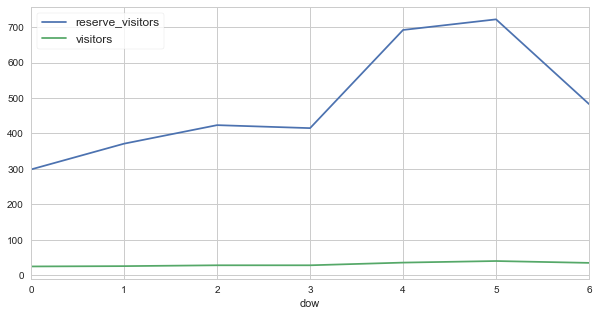

In [55]:
df_train.groupby('dow')[['reserve_visitors', 'visitors']].agg(np.mean).plot(figsize=(10, 5))
plt.legend(frameon=True, fontsize=12)

Reservation peaks at the end of the week, with not much visitors showing up.

Much more reservations in in December/November, stabilyzing during the beginning of the year and going down after June.

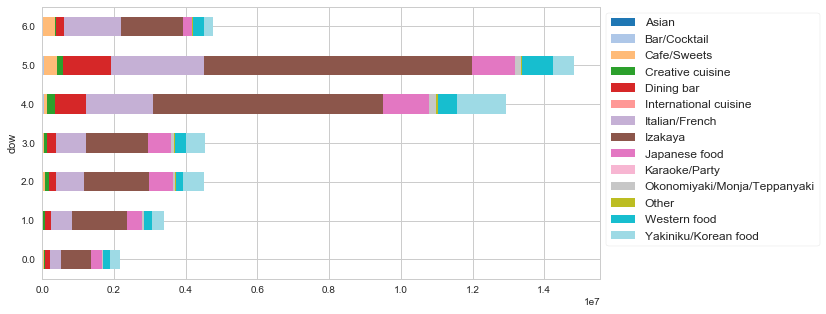

In [57]:
df_train.groupby(['dow', 'air_genre_name'])['reserve_visitors'].sum().unstack().plot(kind='barh', stacked=True, figsize=(10, 5), cmap='tab20')
plt.legend(bbox_to_anchor=(1, 1), frameon=True, fontsize=12)

Preferences seens consistent for diferent time references.

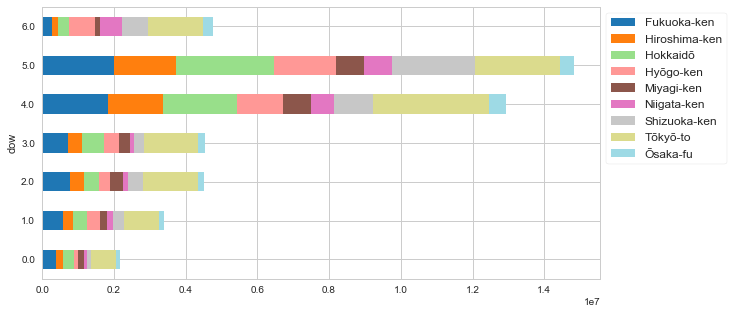

In [60]:
df_train.groupby(['dow', 'area_1'])['reserve_visitors'].sum().unstack().plot(kind='barh', stacked=True, figsize=(10, 5), cmap='tab20')
plt.legend(bbox_to_anchor=(1, 1), frameon=True, fontsize=12)

The same for the preferred areas.

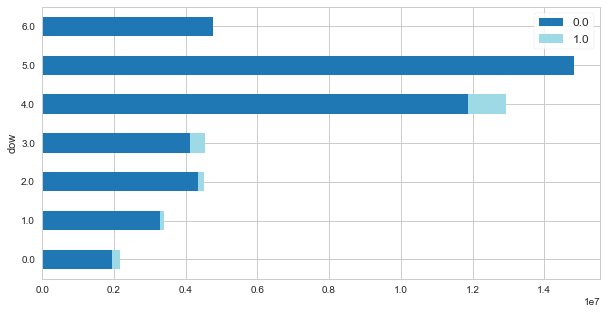

In [62]:
df_train.groupby(['dow', 'holiday_flg'])['reserve_visitors'].sum().unstack().plot(kind='barh', stacked=True, figsize=(10, 5), cmap='tab20')
plt.legend(bbox_to_anchor=(1, 1), frameon=True, fontsize=12)

There are much less reservations in holidays.

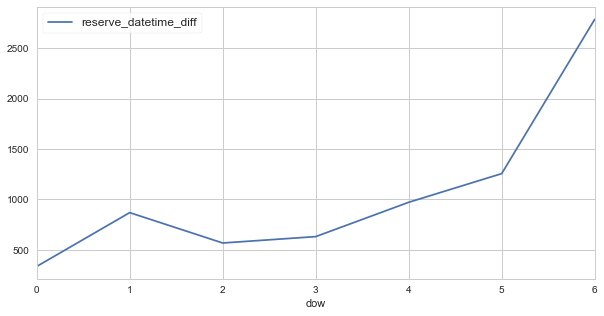

In [64]:
df_train.groupby('dow')[['reserve_datetime_diff']].agg(np.mean).plot(figsize=(10, 5))
plt.legend(frameon=True, fontsize=12)

People planning to show up in the end or beginning of the week reserve in advance.

### Modeling

In [57]:
import missingno as msno

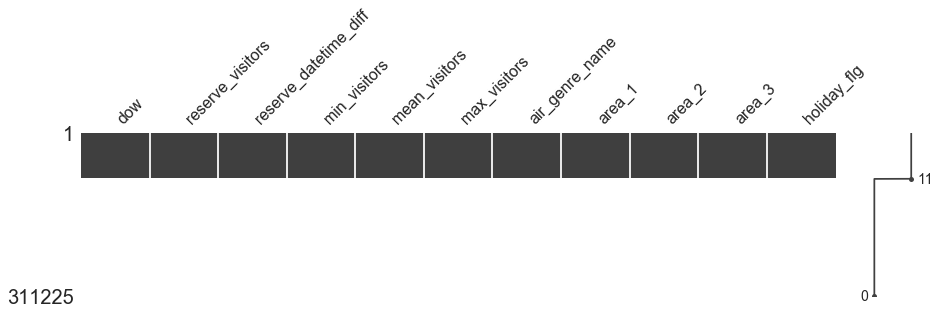

In [58]:
missing_columns = df_train.columns[df_train.isnull().any()].tolist()
if len(missing_columns) > 0:
    msno.matrix(df_train[missing_columns], figsize=(15, 3))

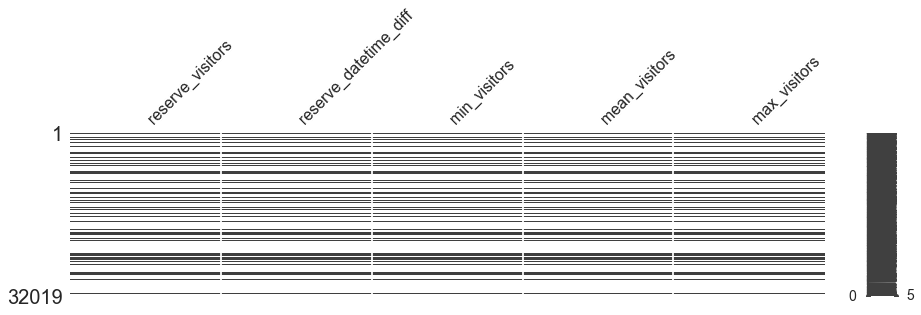

In [59]:
missing_columns = df_test.columns[df_test.isnull().any()].tolist()
if len(missing_columns) > 0:
    msno.matrix(df_test[missing_columns], figsize=(15, 3))

In [60]:
for df in [df_test, df_train]:
    df.sort_values('visit_date', inplace=True)
    df.drop(['visit_date'], axis=1, inplace=True)
    df.fillna(-1, inplace=True)
    
df_train['visitors'] = np.log1p(df_train['visitors'])

In [61]:
categorical = ['air_genre_name', 'area_1', 'area_2', 'area_3', 'dow', 'holiday_flg']

for df in [df_train, df_test]:
    for cat in categorical:
        try:
            df[cat] = df[cat].astype(np.int8)
        except:
            pass

In [62]:
df_both = pd.concat([df_train, df_test])
df_both.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343244 entries, 249719 to 32018
Data columns (total 12 columns):
air_genre_name           343244 non-null object
area_1                   343244 non-null object
area_2                   343244 non-null object
area_3                   343244 non-null object
dow                      343244 non-null int8
holiday_flg              343244 non-null int8
max_visitors             343244 non-null float64
mean_visitors            343244 non-null float64
min_visitors             343244 non-null float64
reserve_datetime_diff    343244 non-null float64
reserve_visitors         343244 non-null float64
visitors                 343244 non-null float64
dtypes: float64(6), int8(2), object(4)
memory usage: 29.5+ MB


In [63]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for cat in categorical:
    print('Category:', cat) 
    le = le.fit(df_both[cat].astype('str'))
    print(le.classes_)
    for df in [df_train, df_test]:
        df[cat] = le.transform(df[cat].astype('str'))
    print(le.transform(le.classes_))

Category: air_genre_name
['-1' 'Asian' 'Bar/Cocktail' 'Cafe/Sweets' 'Creative cuisine' 'Dining bar'
 'International cuisine' 'Italian/French' 'Izakaya' 'Japanese food'
 'Karaoke/Party' 'Okonomiyaki/Monja/Teppanyaki' 'Other' 'Western food'
 'Yakiniku/Korean food']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Category: area_1
['-1' 'Fukuoka-ken' 'Hiroshima-ken' 'Hokkaidō' 'Hyōgo-ken' 'Miyagi-ken'
 'Niigata-ken' 'Shizuoka-ken' 'Tōkyō-to' 'Ōsaka-fu']
[0 1 2 3 4 5 6 7 8 9]
Category: area_2
['-1' 'Abashiri-shi' 'Adachi-ku' 'Amagasaki-shi' 'Asahikawa-shi'
 'Bunkyō-ku' 'Chiyoda-ku' 'Chūō-ku' 'Edogawa-ku' 'Fuchū-shi' 'Fukuoka-shi'
 'Fukuyama-shi' 'Hamamatsu-shi' 'Higashiōsaka-shi' 'Himeji-shi'
 'Hiroshima-shi' 'Itabashi-ku' 'Itoshima-shi' 'Kakogawa-shi'
 'Kashiwazaki-shi' 'Katsushika-ku' 'Katō-gun' 'Kita-ku' 'Kitakyūshū-shi'
 'Koganei-shi' 'Kurume-shi' 'Kōbe-shi' 'Kōtō-ku' 'Machida-shi' 'Meguro-ku'
 'Minato-ku' 'Musashino-shi' 'Nagaoka-shi' 'Nakano-ku' 'Nerima-ku'
 'Neyagawa-shi' 'Niigata-shi

In [64]:
for df in [df_train, df_test]:
    for cat in categorical:
        df[cat] = df[cat].astype('category')

In [65]:
from sklearn.preprocessing import MinMaxScaler

non_categorical_feat = [c for c in df_train.columns if c not in categorical]

scaler = MinMaxScaler(feature_range=(0, 1))
df_train.loc[:, non_categorical_feat] = scaler.fit_transform(df_train[non_categorical_feat])
df_test.loc[:, non_categorical_feat]  = scaler.transform(df_test[non_categorical_feat])

In [66]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311225 entries, 249719 to 311224
Data columns (total 12 columns):
dow                      311225 non-null category
reserve_visitors         311225 non-null float64
reserve_datetime_diff    311225 non-null float64
min_visitors             311225 non-null float64
mean_visitors            311225 non-null float64
max_visitors             311225 non-null float64
air_genre_name           311225 non-null category
area_1                   311225 non-null category
area_2                   311225 non-null category
area_3                   311225 non-null category
holiday_flg              311225 non-null category
visitors                 311225 non-null float64
dtypes: category(6), float64(6)
memory usage: 18.4 MB


In [67]:
from sklearn.model_selection import train_test_split

X_train = df_train.drop(['visitors'], axis=1).copy()
y_train = df_train['visitors'].copy()
X_valid = df_test.drop(['visitors'], axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(X_train.copy(), y_train.copy(), test_size=0.2, random_state=0)

In [68]:
X_train.shape

(248980, 11)

In [69]:
X_test.shape

(62245, 11)

In [70]:
X_valid.shape

(32019, 11)

#### Deep Learning

In [71]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Embedding, LSTM, concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import optimizers
from keras.callbacks import Callback, EarlyStopping
import keras.backend as K

Using TensorFlow backend.


In [72]:
from IPython.display import clear_output

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(self.x, self.losses, label='loss')
        plt.plot(self.x, self.val_losses, label='val_loss')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [73]:
def rmsle(y_true, y_pred):
    first_log  = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

In [74]:
MAX_AREA_1 =  df_both['area_1'].nunique() 
MAX_AREA_2 =  df_both['area_2'].nunique()
MAX_AREA_3 =  df_both['area_3'].nunique() 
MAX_GENRE_NAME = df_both['air_genre_name'].nunique() 
MAX_HOLIDAY = df_both['holiday_flg'].nunique()

In [75]:
print(MAX_AREA_1)
print(MAX_AREA_2)
print(MAX_AREA_3)
print(MAX_GENRE_NAME)
print(MAX_HOLIDAY)

10
56
100
15
15


In [76]:
def get_keras_data(dataset):
    cat_cols = [cat for cat in dataset.columns if any(c in cat for c in categorical)]
    num_cols = dataset.columns.difference(cat_cols)
    
    X = {
        # Categorical
        'area_1' : np.array(dataset['area_1']),
        'area_2' : np.array(dataset['area_2']),
        'area_3' : np.array(dataset['area_3']),
        'air_genre_name' : np.array(dataset['air_genre_name']),
        'dow' : np.array(dataset['dow']),
        'holiday' : np.array(dataset['holiday_flg']),

        # Numerical
        'numerical' : np.array(dataset[num_cols])
    }
    
    return X

X_train_ = get_keras_data(X_train)
X_test_  = get_keras_data(X_test)
X_valid_ = get_keras_data(X_valid)

In [86]:
def get_model():
    dr_r = 0.1
    
    # Categorical
    area_1 = Input(shape=[1], name='area_1')
    area_2 = Input(shape=[1], name='area_2')
    area_3 = Input(shape=[1], name='area_3')
    air_genre_name = Input(shape=[1], name='air_genre_name')
    dow = Input(shape=[1], name='dow')
    holiday = Input(shape=[1], name='holiday')
    
    # Numerical
    numerical = Input(shape=[X_valid_['numerical'].shape[1]], name='numerical')
    
    # Embeddings layers
    emb_area_1 = Embedding(MAX_AREA_1, 5)  (area_1)
    emb_area_2 = Embedding(MAX_AREA_2, 20) (area_2)
    emb_area_3 = Embedding(MAX_AREA_3, 50) (area_3)
    emb_genre_name = Embedding(MAX_GENRE_NAME, 7) (air_genre_name)
    emb_dow = Embedding(7, 4) (dow)
    emb_holiday = Embedding(MAX_HOLIDAY, 7) (holiday)
    
    # Main layer
    main_l = concatenate([
        Flatten() (emb_area_1),
        Flatten() (emb_area_2),
        Flatten() (emb_area_3),
        Flatten() (emb_genre_name),
        Flatten() (emb_dow),
        Flatten() (emb_holiday),
        numerical
    ])
    
    main_l = Dropout(dr_r) (Dense(512, activation='relu') (main_l))
    main_l = Dropout(dr_r) (Dense(256, activation='relu') (main_l))
    main_l = Dropout(dr_r) (Dense(128, activation='relu') (main_l))
    main_l = Dropout(dr_r) (Dense(64, activation='relu')  (main_l))
    
    # Output
    output = Dense(1) (main_l)
    
    # Model
    model = Model([area_1, area_2, area_3, air_genre_name, dow, holiday, numerical], output)
    model.compile(loss='mse', optimizer='adam', metrics=[rmsle])
    
    return model

In [87]:
model = get_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
area_1 (InputLayer)              (None, 1)             0                                            
____________________________________________________________________________________________________
area_2 (InputLayer)              (None, 1)             0                                            
____________________________________________________________________________________________________
area_3 (InputLayer)              (None, 1)             0                                            
____________________________________________________________________________________________________
air_genre_name (InputLayer)      (None, 1)             0                                            
___________________________________________________________________________________________

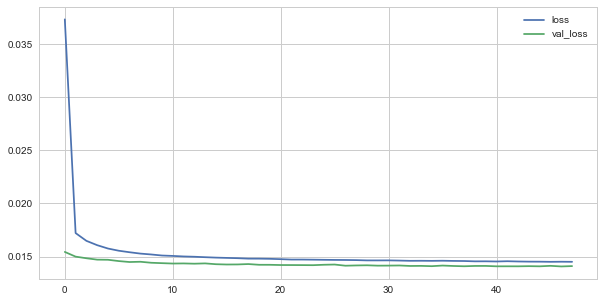

248980/248980 [==============================] - 1s - loss: 0.0145 - rmsle: 0.0701 - val_loss: 0.0141 - val_rmsle: 0.0690


In [88]:
early_stopping = EarlyStopping(monitor='val_rmsle', patience=5)
BATCH_SIZE = 10000
epochs = 200

model = get_model()
model.fit(X_train_, y_train.values, epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_, y_test.values), 
          verbose=1, callbacks=[plot_losses, early_stopping])

In [89]:
y_pred = model.predict(X_valid_)

In [90]:
inv_yhat = pd.concat((X_valid, pd.DataFrame(data=y_pred, columns=['visitors'])), axis=1)

In [91]:
inv_yhat = inv_yhat[non_categorical_feat]

In [92]:
inv_yhat.loc[:, non_categorical_feat] = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat.loc[:, 'visitors']

In [93]:
inv_yhat = np.expm1(inv_yhat)

In [94]:
submission = pd.DataFrame.from_items([('id', df_ids), ('visitors', inv_yhat)])
submission.to_csv('recruiter_dl.csv', index=False)

#### Sklearn

In [95]:
from sklearn.metrics import make_scorer

def rmsle_func(ground_truth, predictions):
    try:
        n_preds, n_targets = predictions.shape
        p = predictions.sum(axis=1)
        a = ground_truth.sum(axis=1)
    except:
        n_preds = len(predictions)
        n_targets = 1
        p = predictions
        a = ground_truth

    sum_squared_error = np.sum((np.log(p + 1) - np.log(a + 1))**2)
    return np.sqrt(1./(n_preds*n_targets) * sum_squared_error)

rmsle = make_scorer(rmsle_func, greater_is_better=False)

In [96]:
from sklearn.model_selection import cross_val_score
import lightgbm as lgbm

In [97]:
X_train.columns

Index(['dow', 'reserve_visitors', 'reserve_datetime_diff', 'min_visitors',
       'mean_visitors', 'max_visitors', 'air_genre_name', 'area_1', 'area_2',
       'area_3', 'holiday_flg'],
      dtype='object')

In [98]:
clf = lgbm.LGBMRegressor(random_state=0)
cols = []

xv = cross_val_score(clf, X_train.drop(cols, axis=1), y_train, scoring=rmsle, cv=3)
print(xv.mean())

-0.0940017161752


In [99]:
clf = clf.fit(X_train.drop(cols, axis=1), y_train)

In [100]:
y_pred = clf.predict(X_valid.drop(cols, axis=1))

In [101]:
inv_yhat = pd.concat((X_valid, pd.DataFrame(data=y_pred, columns=['visitors'])), axis=1)

In [102]:
inv_yhat = inv_yhat[non_categorical_feat]

In [103]:
inv_yhat.loc[:, non_categorical_feat] = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat.loc[:, 'visitors']

In [104]:
inv_yhat = np.expm1(inv_yhat)

In [105]:
submission = pd.DataFrame.from_items([('id', df_ids), ('visitors', inv_yhat)])
submission.to_csv('recruiter_rf.csv', index=False)

#### Time Series

In [43]:
fixed = ['area_head', 'air_genre_name', 'air_area_name']

In [44]:
def df2supervised(df, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars =  df.shape[1]
    n_names = df.columns
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (n_names[j], i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (n_names[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (n_names[j], i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [45]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41614 entries, 38748 to 26812
Data columns (total 14 columns):
reserve_visitors         41614 non-null float64
reserve_datetime_diff    41614 non-null float64
dow                      41614 non-null float64
year                     41614 non-null float64
month                    41614 non-null float64
dom                      41614 non-null float64
min_visitors             41614 non-null float64
mean_visitors            41614 non-null float64
max_visitors             41614 non-null float64
air_genre_name           41614 non-null category
air_area_name            41614 non-null category
area_head                41614 non-null category
holiday_flg              41614 non-null float64
visitors                 41614 non-null float64
dtypes: category(3), float64(11)
memory usage: 3.9 MB


In [46]:
look_back = 1
n_features = df_train.shape[1]-4
train = df2supervised(df_train, n_in=look_back)

In [47]:
for i, c in enumerate(train.columns):
    print(i, c)

0 reserve_visitors(t-1)
1 reserve_datetime_diff(t-1)
2 dow(t-1)
3 year(t-1)
4 month(t-1)
5 dom(t-1)
6 min_visitors(t-1)
7 mean_visitors(t-1)
8 max_visitors(t-1)
9 air_genre_name(t-1)
10 air_area_name(t-1)
11 area_head(t-1)
12 holiday_flg(t-1)
13 visitors(t-1)
14 reserve_visitors(t)
15 reserve_datetime_diff(t)
16 dow(t)
17 year(t)
18 month(t)
19 dom(t)
20 min_visitors(t)
21 mean_visitors(t)
22 max_visitors(t)
23 air_genre_name(t)
24 air_area_name(t)
25 area_head(t)
26 holiday_flg(t)
27 visitors(t)


In [48]:
del_cols = [col for col in train.columns if any(c in col for c in fixed)]

In [49]:
train.drop(train.columns[-15:-1], axis=1, inplace=True)

In [50]:
train.drop(train.columns.intersection(del_cols), axis=1, inplace=True)

In [51]:
train = pd.concat([train, df_train[fixed].shift().dropna()], axis=1)

In [52]:
train.shape

(41613, 14)

In [53]:
train.head()

,reserve_visitors(t-1),reserve_datetime_diff(t-1),dow(t-1),year(t-1),month(t-1),dom(t-1),min_visitors(t-1),mean_visitors(t-1),max_visitors(t-1),holiday_flg(t-1),visitors(t),area_head,air_genre_name,air_area_name
38747,0.002451,0.0,0.666667,0.0,0.0,0.000000,0.019608,0.069612,0.035268,1.0,0.498719,2,4,14
38746,0.004902,0.0,0.666667,0.0,0.0,0.000000,0.019608,0.022002,0.008036,1.0,0.144162,8,4,69
38749,0.001225,0.0,0.666667,0.0,0.0,0.000000,0.039216,0.033563,0.008929,1.0,0.312821,7,8,46
38535,0.001838,0.0,0.666667,0.0,0.0,0.000000,0.019608,0.026484,0.017857,1.0,0.084329,2,4,14
38527,0.000613,0.0,0.833333,0.0,0.0,0.033333,0.019608,0.033551,0.020089,1.0,0.556174,2,8,18


In [54]:
for i, c in enumerate(train.columns):
    print(i, c)

0 reserve_visitors(t-1)
1 reserve_datetime_diff(t-1)
2 dow(t-1)
3 year(t-1)
4 month(t-1)
5 dom(t-1)
6 min_visitors(t-1)
7 mean_visitors(t-1)
8 max_visitors(t-1)
9 holiday_flg(t-1)
10 visitors(t)
11 area_head
12 air_genre_name
13 air_area_name


In [55]:
n_train = int(len(train) * 0.7)
x = train[train.columns.difference(['visitors(t)'])]
y = train['visitors(t)']
X_train = x.iloc[:n_train, :]
X_valid = x.iloc[n_train:, :]
y_train = y.iloc[:n_train]
y_valid = y.iloc[n_train:]

In [56]:
def get_keras_data(dataset):
    cat_cols = [cat for cat in dataset.columns if any(c in cat for c in categorical)]
    num_cols = dataset.columns.difference(cat_cols)
    
    X = {
        # Categorical
        'area_head' : np.array(dataset['area_head']),
        'air_genre_name' : np.array(dataset['air_genre_name']),
        'air_area_name' : np.array(dataset['air_area_name']),

        # Numerical
        'time_series' : np.array(dataset[num_cols]).reshape(dataset[num_cols].shape[0], look_back, n_features)
    }
    
    return X

X_train_ = get_keras_data(X_train)
X_valid_ = get_keras_data(X_valid)

In [61]:
def get_model():
    dr_r = 0.45
    
    # Categorical
    area_head = Input(shape=[1], name='area_head')
    air_genre_name = Input(shape=[1], name='air_genre_name')
    air_area_name = Input(shape=[1], name='air_area_name')
    
    # LSTM
    time_series = Input(shape=(X_train_['time_series'].shape[1], X_train_['time_series'].shape[2]), name='time_series')
    
    # Embeddings layers
    emb_area_head  = Embedding(MAX_AREA_HEAD, 3) (area_head)
    emb_genre_name = Embedding(MAX_GENRE_NAME, 20) (air_genre_name)
    emb_air_area_name = Embedding(MAX_AREA_NAME, 3) (air_area_name)
    
    time_series_lstm = LSTM(50) (time_series)
    
    # Main layer
    main_l = concatenate([
        Flatten() (emb_area_head),
        Flatten() (emb_genre_name),
        Flatten() (emb_air_area_name),
        time_series_lstm
    ])
    
    main_l = Dropout(dr_r) (Dense(128, activation='relu') (main_l))
    main_l = Dropout(dr_r) (Dense(64, activation='relu') (main_l))
    
    # Output
    output = Dense(1) (main_l)
    
    # Model
    model = Model([area_head, air_genre_name, air_area_name, time_series], output)
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [62]:
model = get_model()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
area_head (InputLayer)           (None, 1)             0                                            
____________________________________________________________________________________________________
air_genre_name (InputLayer)      (None, 1)             0                                            
____________________________________________________________________________________________________
air_area_name (InputLayer)       (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 3)          30          area_head[0][0]                  
___________________________________________________________________________________________

In [64]:
X_train_

{'air_area_name': array([14, 69, 46, ..., 44, 11, 11], dtype=int64),
 'air_genre_name': array([ 4,  4,  8, ...,  6,  4, 10], dtype=int64),
 'area_head': array([2, 8, 7, ..., 7, 1, 1], dtype=int64),
 'time_series': array([[[  0.00000000e+00,   6.66666667e-01,   1.00000000e+00, ...,
            0.00000000e+00,   2.45098039e-03,   0.00000000e+00]],
 
        [[  0.00000000e+00,   6.66666667e-01,   1.00000000e+00, ...,
            0.00000000e+00,   4.90196078e-03,   0.00000000e+00]],
 
        [[  0.00000000e+00,   6.66666667e-01,   1.00000000e+00, ...,
            0.00000000e+00,   1.22549020e-03,   0.00000000e+00]],
 
        ..., 
        [[  3.33333333e-01,   8.33333333e-01,   1.00000000e+00, ...,
            1.47490450e-05,   6.12745098e-03,   1.00000000e+00]],
 
        [[  3.33333333e-01,   8.33333333e-01,   1.00000000e+00, ...,
            2.50733765e-04,   1.47058824e-02,   1.00000000e+00]],
 
        [[  3.33333333e-01,   8.33333333e-01,   1.00000000e+00, ...,
            3.09729

In [65]:
X_valid_

{'air_area_name': array([11, 53, 10, ...,  7,  0,  8], dtype=int64),
 'air_genre_name': array([10,  8,  7, ...,  4,  7,  4], dtype=int64),
 'area_head': array([1, 7, 1, ..., 0, 0, 0], dtype=int64),
 'time_series': array([[[  3.33333333e-01,   8.33333333e-01,   1.00000000e+00, ...,
            7.37452250e-04,   1.65441176e-02,   1.00000000e+00]],
 
        [[  3.33333333e-01,   8.33333333e-01,   1.00000000e+00, ...,
            4.42471350e-04,   2.45098039e-03,   1.00000000e+00]],
 
        [[  3.33333333e-01,   8.33333333e-01,   1.00000000e+00, ...,
            1.04718219e-03,   1.89950980e-02,   1.00000000e+00]],
 
        ..., 
        [[  7.00000000e-01,   8.33333333e-01,   0.00000000e+00, ...,
            5.89961800e-04,   3.67647059e-03,   1.00000000e+00]],
 
        [[  7.00000000e-01,   8.33333333e-01,   0.00000000e+00, ...,
            6.78456070e-04,   2.02205882e-02,   1.00000000e+00]],
 
        [[  7.00000000e-01,   8.33333333e-01,   0.00000000e+00, ...,
            1.03243

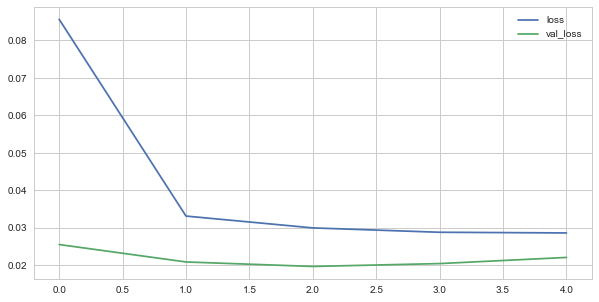

29129/29129 [==============================] - 0s - loss: 0.0286 - val_loss: 0.0221


In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
BATCH_SIZE = 1000
epochs = 5

model = get_model()
model.fit(X_train_, y_train, epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_valid_, y_valid), 
          verbose=1, shuffle=False, callbacks=[plot_losses, early_stopping])